In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys
import pickle

import pandas as pd

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, Layer
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import keras.backend as K

try:
    from google.colab import files
    colab = True
except ImportError:
    colab = False

Using TensorFlow backend.


In [3]:
diag = lambda x: np.diag(np.diag(x))

In [4]:
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{bm},\usepackage{amsmath},\usepackage{amssymb}"

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 9
plt.rcParams["legend.fontsize"] = 8

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = 3.2, 1.98

# 2. Method

## 2.1 Series Expansion

In [5]:
def logZ_expansion(expectation, variance, lamb=1):
    return -lamb * expectation + lamb**2 / 2 * variance

## 2.2 Analytic Method (PPCA)

In [5]:
def expectation_V(x, W, b, sigma, method='matmul'):
    # the method keyword specifies whether to use tensordot or matmul to calcuate log_p_x
    # tensordot is faster, but does not do elementwise operations, so you lose info over x
    # matmul is slower, but is elementwise for x
    d, l = W.shape
    N = len(x)
    M = matmul(W.T, W) + sigma * eye(l)
    C = matmul(W, W.T) + sigma * eye(d)
    
    if method == 'matmul':
        log_p_x = -1/2 * linalg.slogdet(2 * pi * C)[1] - 1/2 * matmul(matmul((x-b).transpose(0, 2, 1), inv(C)), x-b)
    elif method == 'tensordot':
        log_p_x = -1/2 * linalg.slogdet(2 * pi * C)[1] - 1/(2*N) * tensordot(matmul((x[:,:,0]-b[:,0]), inv(C)), x[:,:,0]-b[:,0])
    
    elbo = log_p_x - 1/2 * linalg.slogdet(diag(M))[1] + 1/2 * linalg.slogdet(M)[1]
    
    return -elbo

def variance_V(W, sigma):
    d, l = W.shape
    M = matmul(W.T, W) + sigma * eye(l)
    inner = linalg.matrix_power(matmul(M-diag(M), inv(diag(M))), 2)
    return 1/2 * trace(inner)

In [6]:
def calculate_W_sigma(x, S, l=2):
    # find the eigs and eigenvectors of the cov matrix and sort according
    eigs, evecs = linalg.eig(S)
    eig_pairs = list(zip(eigs, evecs.T))
    eig_pairs.sort(reverse=True, key=lambda x: x[0])

    # select the top q principle components
    d = len(eig_pairs)

    pca_pairs = eig_pairs[:l]
    
    pca_eigs = [pca_pairs[i][0] for i in range(len(pca_pairs))]
    pca_vecs = [pca_pairs[i][1] for i in range(len(pca_pairs))]

    # construct W and sigma^2
    L_q = np.diag(pca_eigs)
    U_q = array(pca_vecs).T
    sigma = 1/(d-l) * np.sum([eig_pairs[j][0] for j in range(l+1, d)]) #technically inverse sigma
    W = np.matmul(U_q, L_q - sigma * eye(l))
    return W, sigma
    
def calculate_elbo(x, W, sigma, R=None, method='tensordot'):
    # find shape of W
    d, l = W.shape
    N = len(x)
    
    # find the mean of x
    b = np.mean(x, axis=0)
    
    # rotate W if it is a 2d matrix
    if R is not None:
        W = matmul(W, R)

    # find p(z|x)
    M = matmul(W.T, W) + sigma * eye(l)
    p_z_x_mu = matmul(matmul(inv(M), W.T), (x-b))
    p_z_x_sig = sigma * inv(M)

    # find best q(z|x)
    q_z_x_mu = matmul(matmul(inv(M), W.T), (x-b))
    q_z_x_sig = sigma * inv(diag(M))

    # find p(x)
    p_x_mu = b
    p_x_sig = matmul(W, W.T) + sigma * eye(d)
    inv_p = inv(p_x_sig)

    # find p(x|z)
    p_x_z_mu = lambda z: matmul(W, z.T).T + b
    p_x_z_sig = sigma * eye(d)

    # calculate log p(x)
    detsign, detlog = linalg.slogdet(2*pi*p_x_sig)
    if method == 'matmul':
        log_p_x = -1/2 * detlog - 1/2 * matmul(matmul((x-p_x_mu).transpose(0, 2, 1), inv_p), x-p_x_mu)
    elif method == 'tensordot':
        log_p_x = -1/2 * detlog - 1/(2*N) * tensordot(matmul(x[:,:,0]-p_x_mu[:,0], inv_p), x[:,:,0]-p_x_mu[:,0])
    log_p_x_mean = np.mean(log_p_x)

    # # calculate the elbo stochastically
    # z_samples = q_z_x_mu + np.expand_dims(random.multivariate_normal(zeros(l), q_z_x_sig, size=len(q_z_x_mu)), -1)
    # x_z_mu = p_x_z_mu(z_samples)

    # log_p = lambda x, mu, sig: -1/2 * linalg.slogdet(2*pi*sig)[1] - 1/2 * matmul(matmul((x-mu).transpose(0, 2, 1), inv(sig)), x-mu)
    # log_p_x_z = log_p(x, x_z_mu, p_x_z_sig)
    # log_p_z = log_p(z_samples, zeros((l, 1)), eye(l))
    # log_q_z_x = log_p(z_samples, q_z_x_mu, q_z_x_sig)

    # pca_elbo = log_p_x_z + log_p_z - log_q_z_x
    # pca_elbo_mean = np.mean(pca_elbo)

    # calculate the elbo analytically
    elbo = log_p_x - 1/2 * linalg.slogdet(diag(M))[1] + 1/2 * linalg.slogdet(M)[1]
    elbo_mean = np.mean(elbo)
    
    # calculate the variance analytically
    variance = variance_V(W, sigma)
    
    return log_p_x_mean, elbo_mean, variance

## 2.3 Neural Network

In [7]:
def encoder(latent_dim, hidden_dim=200):
    enc_in = Input(shape=(784,1), name='enc_input')
    enc_flat = Flatten(name='enc_flat')(enc_in)
    enc_hid = Dense(hidden_dim, activation='relu', name='enc_hidden')(enc_flat)
    enc_hid2 = Dense(hidden_dim, activation='relu', name='enc_hidden2')(enc_hid)
    z_mean = Dense(latent_dim, name='latent_mean')(enc_hid2)
    log_z_var = Dense(latent_dim, name='log_latent_var')(enc_hid2)
    enc_model = Model(enc_in, [z_mean, log_z_var], name='encoder_model')
    return enc_model, (z_mean, log_z_var)

def decoder(latent_dim, hidden_dim=200, model='bernoulli'):
    dec_in = Input(shape=(latent_dim,), name='dec_in')
    dec_hid = Dense(hidden_dim, activation='relu', name='dec_hidden')(dec_in)
    dec_hid2 = Dense(hidden_dim, activation='relu', name='dec_hidden2')(dec_hid)
    dec_out = Dense(28*28, activation='sigmoid', name='dec_flat')(dec_hid2)
    dec_out = Reshape((784, 1), name='dec_out')(dec_out)
    dec_model = Model(dec_in, dec_out, name='decoder_model')
    return dec_model

In [8]:
class Sampler(Layer):
    
    def __init__(self, always_sample=False, **kwargs):
        self.always_sample = always_sample
        super(Sampler, self).__init__(**kwargs)
    
    def call(self, x, training=None):
        assert isinstance(x, list)
        z_mean, log_z_var = x
        z_std = K.exp(log_z_var/2)
        
        # sample epsilon from N(0, stddev)
        shape = K.shape(z_mean)
        epsilon = K.random_normal(shape, mean=0, stddev=1)
        z_sample = z_mean + z_std * epsilon
        
        if self.always_sample:
            return z_sample
        else:
            return K.in_train_phase(z_sample, z_mean, training=training)
    
    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        return input_shape[0]

In [9]:
def bernoulli_elbo(y_true, y_pred):
    kl_loss = 0.5 * np.sum(1 + log_z_var - np.square(z_mean) - np.exp(log_z_var), axis=-1)
    im_loss = np.sum(y_true * np.log(y_pred + 1e-30) + (1-y_true) * np.log(1-y_pred + 1e-30), axis=(-1, -2))
    return kl_loss + im_loss

In [121]:
def mc_estimate_iwae_V(x, batch_size=32, samples=1000, verbose=2):
    steps = int(np.ceil(len(x) / batch_size))
    elbo = zeros(len(x))
    mean_V = zeros(len(x))
    var_V = zeros(len(x))
    im_loss = zeros(len(x))
    kl_loss = zeros(len(x))
    for i in range(steps):
        batch = x[i*batch_size:(i+1)*batch_size]
        z_mean, log_z_var = encoder_model.predict(batch, batch_size=2000)
        z_samples = z_mean + np.random.normal(0, 1, size=(samples, *z_mean.shape)) * np.exp(log_z_var/2)
        batch_pred = decoder_model.predict(z_samples.reshape(samples * len(batch), latent_dim), batch_size=1000)
        batch_pred = batch_pred.reshape(samples, len(batch), *batch.shape[1:])
        
        log_p_x_z = np.sum(batch * np.log(batch_pred+1e-30) + (1-batch) * np.log(1-batch_pred+1e-30), axis=(-1, -2)) #log p(x|z)
        log_q_by_p = 1/2 * np.sum(z_samples**2 - log_z_var - np.exp(-log_z_var)*(z_samples-z_mean)**2, axis=-1) #log (q(z|x)/p(z))
        V_z = - log_p_x_z + log_q_by_p
        
        elbo[i*batch_size:(i+1)*batch_size] = np.log(np.mean(np.exp(-V_z), axis=0)) #iwae estimate
        mean_V[i*batch_size:(i+1)*batch_size] = np.mean(V_z, axis=0)
        var_V[i*batch_size:(i+1)*batch_size] = np.var(V_z, axis=0, ddof=1)
        im_loss[i*batch_size:(i+1)*batch_size] = np.mean(log_p_x_z, axis=0)
        kl_loss[i*batch_size:(i+1)*batch_size] = -np.mean(log_q_by_p, axis=0)
        
        # logging
        if verbose != 0:
            curr_elbo = np.mean(elbo[:(i+1)*batch_size])
            curr_im_loss = np.mean(im_loss[:(i+1)*batch_size])
            curr_kl_loss = np.mean(kl_loss[:(i+1)*batch_size])
        if verbose == 1:
            print('Step %d/%d completed: ELBO: %.3f  -  im_loss: %.3f  -  kl_loss: %.3f' %(i+1, steps, curr_elbo, curr_im_loss, curr_kl_loss))
        elif verbose == 2:
            sys.stdout.write('\rStep %d/%d completed: ELBO: %.3f  -  im_loss: %.3f  -  kl_loss: %.3f' %(i+1, steps, curr_elbo, curr_im_loss, curr_kl_loss))
            sys.stdout.flush()
    return elbo, mean_V, var_V, im_loss, kl_loss

In [11]:
def binarize_generator(x, batch_size, shuffle=True):
    x = np.random.permutation(x) if shuffle else x
    nb_batch = 0
    
    while True:
        batch = x[nb_batch*batch_size:(nb_batch+1)*batch_size]
        y = batch > np.random.rand(*batch.shape)
        
        nb_batch += 1
        if nb_batch >= np.ceil(len(x) / batch_size):
            x = np.random.permutation(x) if shuffle else x
            nb_batch = 0
            
        yield y, y

# 3. Results

## 3.1. Data

### 3.1.1. Generated

In [12]:
# generate data
mean = zeros(5)
S_gen = 1/2 * array([
    [1, 0.9, 0.8, 0.7, 0.6],
    [0, 1, 0.9, 0.8, 0.7],
    [0, 0, 1, 0.9, 0.8],
    [0, 0, 0, 1, 0.9],
    [0, 0, 0, 0, 1]
])
S_gen = S_gen + S_gen.T
x_gen = np.random.multivariate_normal(mean, S_gen, size=(60000,))
x_gen = np.expand_dims(x_gen, -1)

### 3.1.2. MNIST

In [13]:
def preprocess(data):
    x, y = data
    x = x.reshape((len(x), 784))
    x = x/255.
    x = np.expand_dims(x, -1)
    #y = to_categorical(y, 10) # don't need to categorise y
    return x, y

train, test = mnist.load_data()

x_train, y_train = preprocess(train)
x_test, y_test = preprocess(test)

# for VAEs, binarize the data
x_train_bin = x_train > np.random.rand(*x_train.shape)
x_test_bin = x_test > np.random.rand(*x_test.shape)

## 3.2. Analytic Model

In [14]:
if not os.path.exists('./S.npy'):
    b = np.mean(x_train, axis=0)
    S = 0
    for x in x_train:
        S+= np.outer(x-b, x-b)
    S /= len(x_train)
    np.save('./S.npy', S)

S = np.load('./S.npy')

In [15]:
W_gen, sigma_gen = calculate_W_sigma(x_gen, S_gen, l=2)
W, sigma = calculate_W_sigma(x_train, S, l=2)

### 3.2.1. Result 1
Sweep $W_{ML}$ for $\ell=2$ and show that the ELBO is maximsied for an orthogonal $\mathbf{M}$ on a _generated dataset_.

In [215]:
alpha = linspace(0, pi, 100)
rotate_2 = lambda theta: array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
generated_elbos = array([calculate_elbo(x_gen, W_gen, sigma_gen, R=rotate_2(a)) for a in alpha])

log_p_x_gen = generated_elbos[:, 0]
elbo_gen = generated_elbos[:, 1]
var_gen = generated_elbos[:, 2]
second_gen = elbo_gen + 1/2 * var_gen

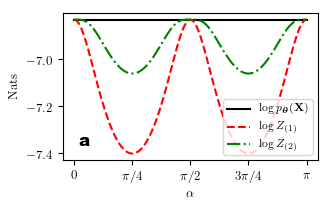

In [216]:
plot(theta, log_p_x_gen, '-k', label=r'$\log p_{\bm{\theta}}(\mathbf{X})$')
plot(theta, elbo_gen, '--r', label=r'$\log Z_{(1)}$')
plot(theta, second_gen, '-.g', label=r'$\log Z_{(2)}$')

legend(loc=4)

xticks((0, pi/4, pi/2, 3*pi/4, pi), labels=(r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'))
xlabel(r'$\alpha$')

ylabel(r'Nats')

text(0.1/1.618, 0.1, 'a',
     fontdict = {
         'family': 'sans-serif',
         'name': 'arial',
         'size': 12,
         'weight': 'black',
         'usetex': False
     },
     transform=gca().transAxes
)

savefig('./Figures/generated_logZ_v_theta_l02.pdf')

### 3.2.2. Result 2
Sweep $W_{ML}$ for $\ell=2$ and show that the ELBO is maximsied for an orthogonal $\mathbf{M}$ on the _MNIST dataset_.

In [217]:
alpha = linspace(0, pi, 100)
rotate_2 = lambda theta: array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
mnist_elbos = array([calculate_elbo(x_train, W, sigma, R=rotate_2(a)) for a in alpha])

log_p_x_mnist = mnist_elbos[:, 0]
elbo_mnist = mnist_elbos[:, 1]
var_mnist = mnist_elbos[:, 2]
second_mnist = elbo_mnist + 1/2 * var_mnist

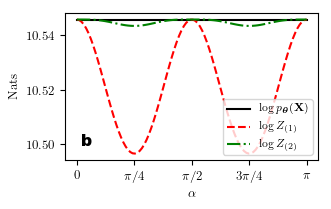

In [218]:
plot(theta, log_p_x_mnist, '-k', label=r'$\log p_{\bm{\theta}}(\mathbf{X})$')
plot(theta, elbo_mnist, '--r', label=r'$\log Z_{(1)}$')
plot(theta, second_mnist, '-.g', label=r'$\log Z_{(2)}$')

legend(loc=4)

xticks((0, pi/4, pi/2, 3*pi/4, pi), labels=(r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'))
xlabel(r'$\alpha$')

ylabel(r'Nats')

text(0.1/1.618, 0.1, 'b',
     fontdict = {
         'family': 'sans-serif',
         'name': 'arial',
         'size': 12,
         'weight': 'black',
         'usetex': False
     },
     transform=gca().transAxes
)

gcf().savefig('./Figures/mnist_logZ_v_theta_l02.pdf')

### 3.2.3. Result 3
Comparing second order t=correct term between MNIST and the gneerated set.

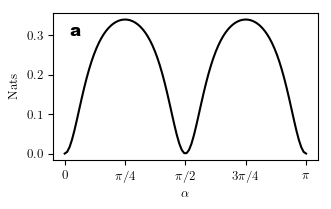

In [328]:
plot(theta, 1/2 * var_gen, '-k', label='Generated')

# legend(loc=1)

xticks((0, pi/4, pi/2, 3*pi/4, pi), labels=(r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'))
xlabel(r'$\alpha$')

text(0.1/1.618, 0.85, 'a',
     fontdict = {
         'family': 'sans-serif',
         'name': 'arial',
         'size': 12,
         'weight': 'black',
         'usetex': False
     },
     transform=gca().transAxes
)

ylabel(r'Nats')

gcf().savefig('./Figures/generated_var_l02.pdf')

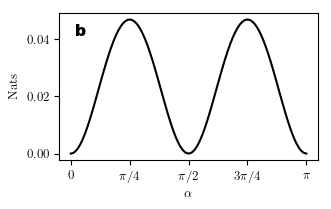

In [329]:
plot(theta, 1/2 * var_mnist, '-k', label='MNIST')
# plot(theta, var_gen, '-.b', label='Generated')

# legend(loc=1)

xticks((0, pi/4, pi/2, 3*pi/4, pi), labels=(r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'))
xlabel(r'$\alpha$')

text(0.1/1.618, 0.85, 'b',
     fontdict = {
         'family': 'sans-serif',
         'name': 'arial',
         'size': 12,
         'weight': 'black',
         'usetex': False
     },
     transform=gca().transAxes
)

ylabel(r'Nats')

gcf().savefig('./Figures/mnist_var_l02.pdf')

### 3.2.4 Result 4
Sweeping $\mathbf{W}_{ML}$ over non-leading PCA axes.

Text(0, 0.5, 'Nats')

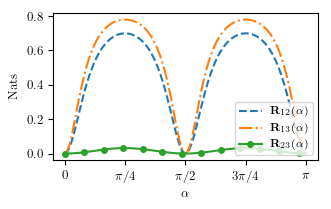

In [311]:
W_gen, sigma_gen = calculate_W_sigma(x_gen, S_gen, l=3)

rotate_3_12 = lambda theta: array([[cos(theta), -sin(theta), 0], [sin(theta), cos(theta), 0], [0, 0, 1]])
rotate_3_13 = lambda theta: array([[cos(theta), 0, -sin(theta)], [0, 1, 0], [sin(theta), 0, cos(theta)]])
rotate_3_23 = lambda theta: array([[1, 0, 0], [0, cos(theta), -sin(theta)], [0, sin(theta), cos(theta)]])
rotates = [rotate_3_12, rotate_3_13, rotate_3_23]
labels = ['12', '13', '23']
styles = ['--', '-.', '-o']

alpha = linspace(0, pi, 100)

log_p_x_rot, _, _ = calculate_elbo(x_gen, W_gen, sigma_gen)
plot(alpha, [log_p_x_rot] * len(alpha), '-k', label = r'$\log p_{\bm{\theta}}(\mathbf{X})$')

for i, rotate in enumerate(rotates):
    rotated_elbos = array([calculate_elbo(x_gen, W_gen, sigma_gen, R=rotate(a)) for a in alpha])

    log_p_x_rot = rotated_elbos[:, 0]
    elbo_rot = rotated_elbos[:, 1]
    var_rot = rotated_elbos[:, 2]
    second_rot = elbo_rot + 1/2 * var_rot
    
    plot(alpha, second_rot, styles[i], label = r'$\mathbf{R}_{%s}(\alpha)$' %labels[i], markevery=8, ms=4)
    
legend(loc=4)

xticks((0, pi/4, pi/2, 3*pi/4, pi), labels=(r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'))
xlabel(r'$\alpha$')

ylabel(r'Nats')

## 3.3 Neural Network - Bernoulli Model

In [122]:
latent_dim = 50

encoder_model, (z_mean, log_z_var) = encoder(latent_dim)
decoder_model = decoder(latent_dim)
z_sampler = Sampler(always_sample=True, name='z_sampler')([z_mean, log_z_var])

vae_model = Model(encoder_model.input, decoder_model(z_sampler))

def bernoulli_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.sum(1 + log_z_var - K.square(z_mean) - K.exp(log_z_var), axis=-1)
    im_loss = K.sum(K.binary_crossentropy(y_true, y_pred), axis=(-1, -2)) # computes -log p(x|z)
    return kl_loss + im_loss

vae_model.compile(optimizer='adam', loss=bernoulli_loss)

# train and save the model

if not os.path.exists('./models/'):
    os.makedirs('./models/bernoulli/')

dec_path = './models/bernoulli/dec_model_%d_dim.weights' %latent_dim
weights_path = './models/bernoulli/vae_model_%d_dim.weights' %latent_dim
history_path = './models/bernoulli/history_%d_dim.pkl' %latent_dim

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=10**(-1/7), patience=10, min_lr=1e-4, verbose=1)
nb_regions = 6
regions = cumsum([3**i for i in range(nb_regions+1)])
schedule = lambda i, lr: 0.001 * 10**(-sum(regions <= i)/nb_regions)

lr_schedule = LearningRateScheduler(schedule)
# early_stop = EarlyStopping(monitor='loss', patience=50, verbose=1)

epochs = regions[-1]
batch_size = 512
steps_per_epoch = np.ceil(len(x_train) / batch_size)

if not os.path.exists(weights_path):
    # training
    history = vae_model.fit_generator(
        binarize_generator(x_train, batch_size),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=[lr_schedule]
    )
    # enc_dec_model represents the whole dec_model as a single layer
    # so we have to save the decoder weights seperately
    decoder_model.save_weights(dec_path) # hacky fix for decoder weights
    vae_model.save_weights(weights_path)
    # save history
    history = history.history
    pickle.dump(history, open(history_path, 'wb'))
    print('Model Saved')
else:
    decoder_model.load_weights(dec_path, by_name=True)
    encoder_model.load_weights(weights_path, by_name=True)
    vae_model.load_weights(weights_path, by_name=True)
    history = pickle.load(open(history_path, 'rb'))
    print('Model Loaded')
    

Model Loaded


In [123]:
if colab:
    files.download(weights_path)
    files.download(dec_path)
    files.download(history_path)

In [124]:
iwae_test_path = './data/nips/test_iwae_mean_V_l%d.csv' %latent_dim
if not os.path.exists(iwae_test_path):
    iwae, mean_V, var_V, im_loss, kl_loss = mc_estimate_iwae_V(x_test_bin, batch_size=16, samples=5000)

    df = pd.DataFrame(
        data = array([y_test, iwae, -mean_V, var_V, -mean_V + 1/2 * var_V, im_loss, kl_loss]).T, 
        columns=['class', 'iwae', 'mean_V', 'var_V', 'second_V', 'im_loss', 'kl_loss']
    )

    df.to_csv(iwae_test_path, index=False)
else:
    df = pd.read_csv(iwae_test_path)

Step 625/625 completed: ELBO: -88.069  -  im_loss: -66.390  -  kl_loss: -26.095

In [125]:
np.mean(-mean_V + 1/2 * var_V)

-87.48721836968984

### 3.3.1 Result 5
Plot samples from the test data with the largest elbo and lowest variance per class.

In [109]:
def get_reconstruction_samples(images, samples=5, reshape=True):
    z_mean, log_z_var = encoder_model.predict(images > np.random.rand(*images.shape))
    z_samples = z_mean + np.exp(log_z_var/2) * np.random.normal(0, 1, size=(samples, *z_mean.shape))
    z_samples = z_samples.reshape(len(images) * samples, z_mean.shape[-1])
    sample_images = decoder_model.predict(z_samples)
    sample_images = sample_images.reshape(samples, len(images), 28, 28)
    if reshape:
        reshaped = zeros((len(images), 28, 28*samples))
        for i, sample in enumerate(sample_images):
            reshaped[:, :, i*28:(i+1)*28] = sample
        return reshaped
    return sample_images

def plot_save_min_max(classes, label, images, samples=5):
    for i, image in enumerate(images):
        fig, ax = plt.subplots(figsize=(3.2, 3.2), constrained_layout=True)
        ax.imshow(image.reshape(28, 28), cmap='Greys')
        ax.set_xticks(())
        ax.set_yticks(())
        fig.savefig('./Figures/' + label + '/' + str(classes[i]) + '_' + label + '_data_l%d.pdf' %latent_dim)
    
    # now take samples from the reconstruction
    sample_images = get_reconstruction_samples(images, samples=samples)
    for number, sample in zip(classes, sample_images):
        fig, ax = plt.subplots(figsize=(3.2*samples, 3.2), constrained_layout=True)
        ax.imshow(sample, cmap='Greys')
        ax.set_xticks(())
        ax.set_yticks(())
        fig.savefig('./Figures/' + label + '/' + str(number) + '_' + label + '_samples_l%d.pdf' %latent_dim)

C:\Users\User\Anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


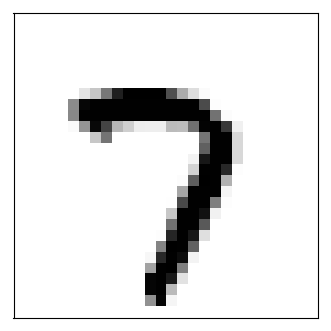

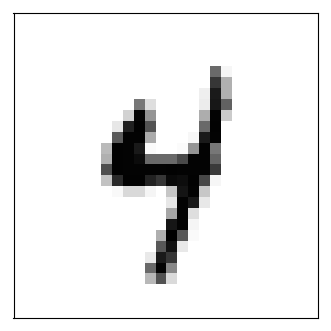

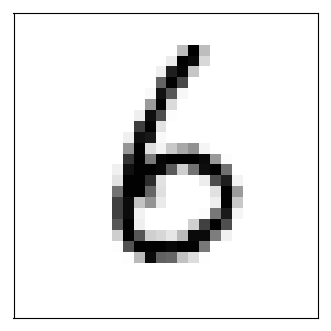

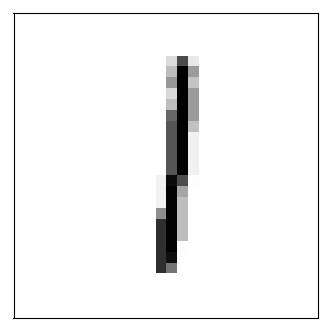

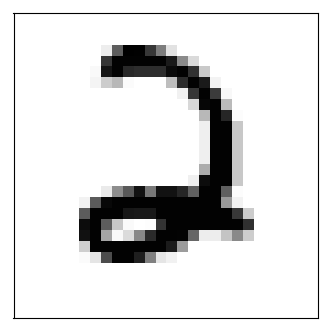

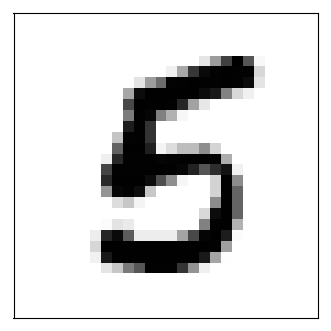

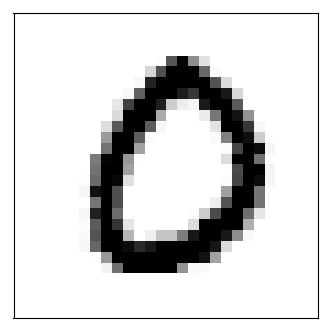

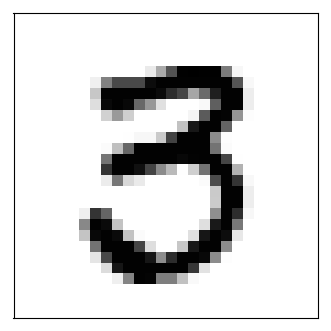

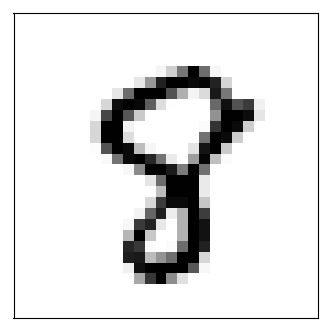

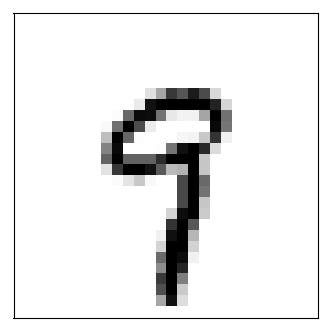

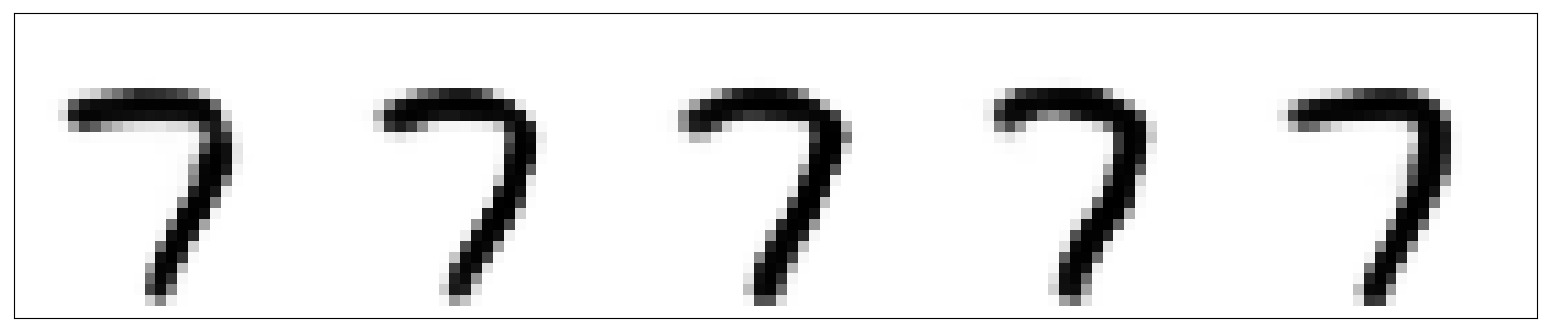

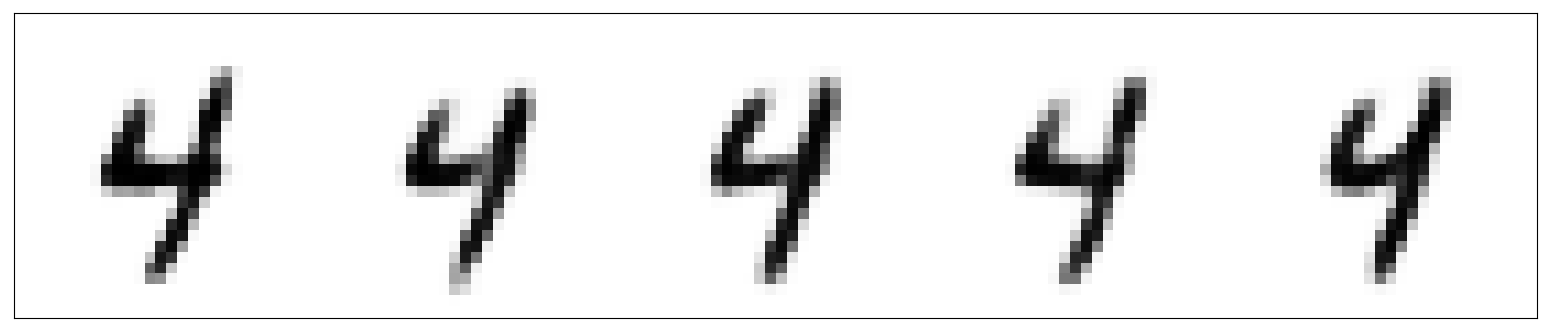

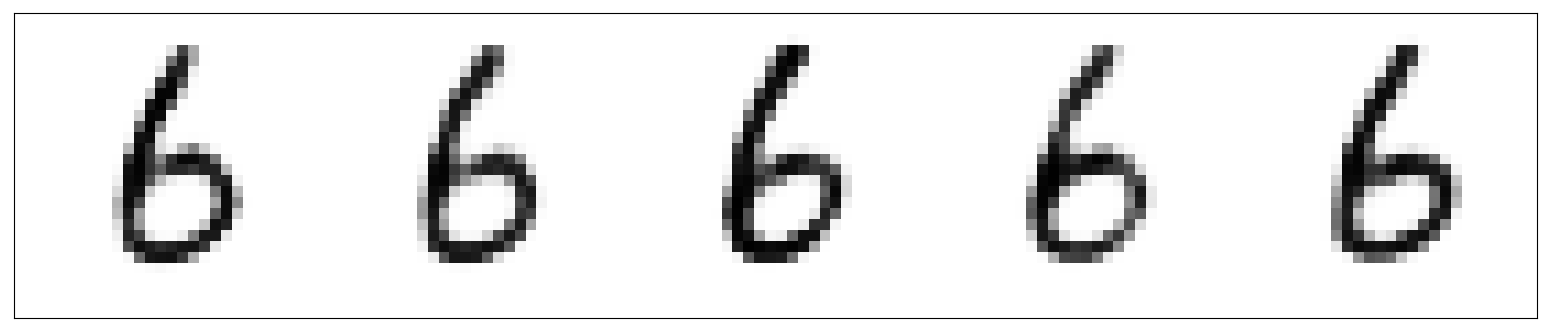

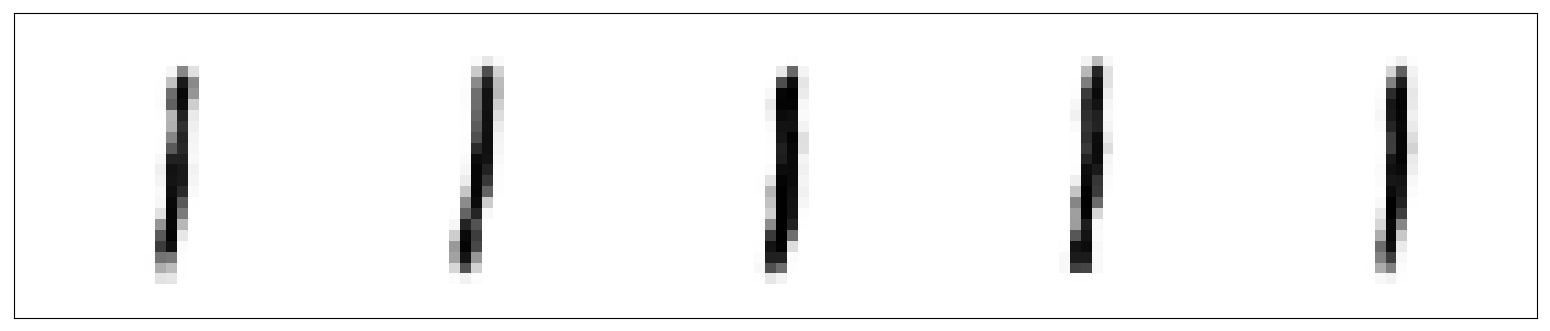

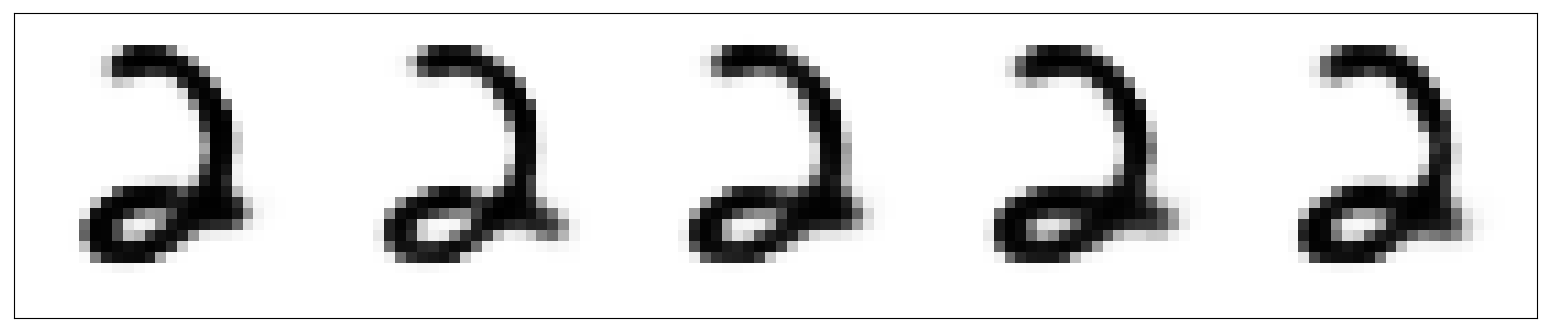

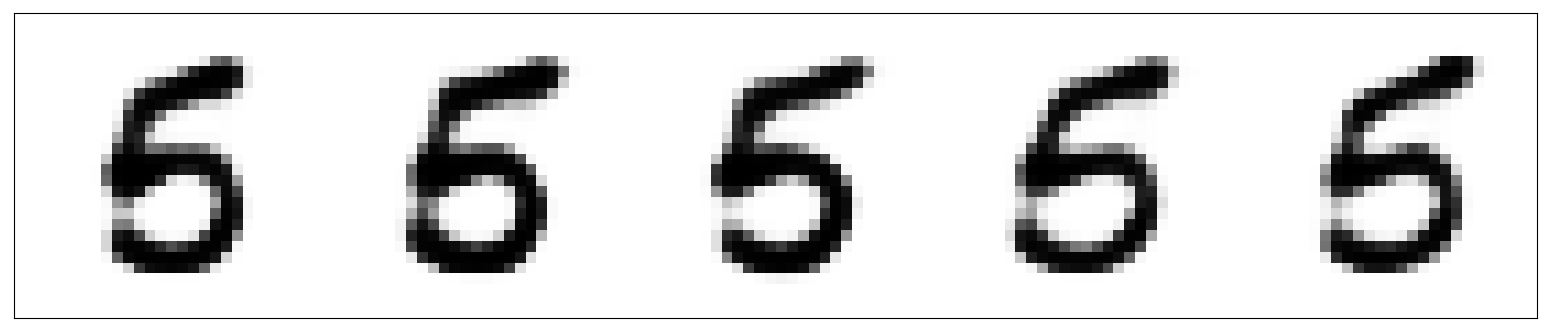

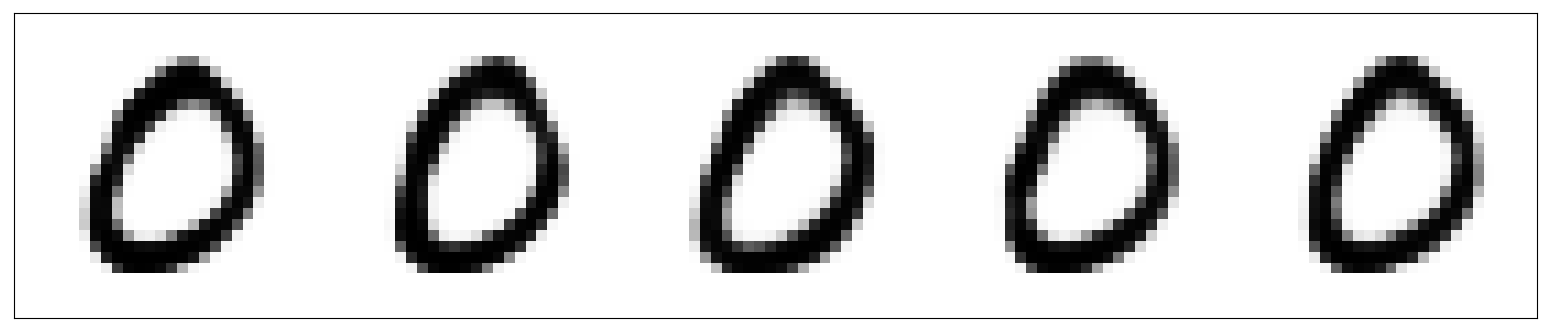

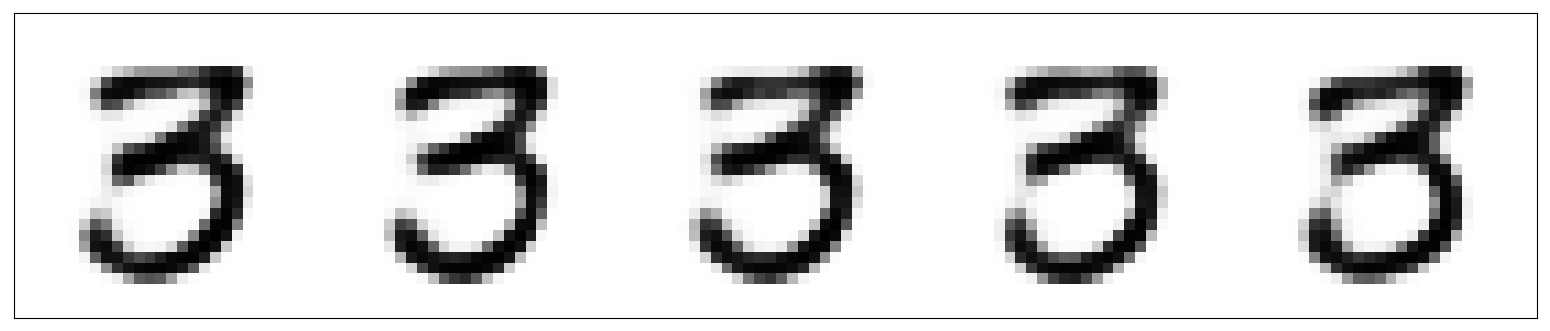

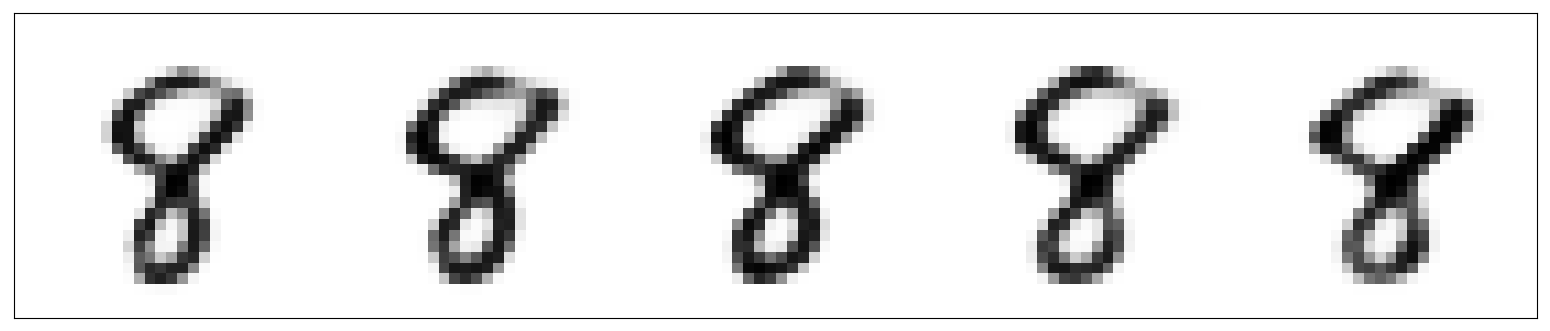

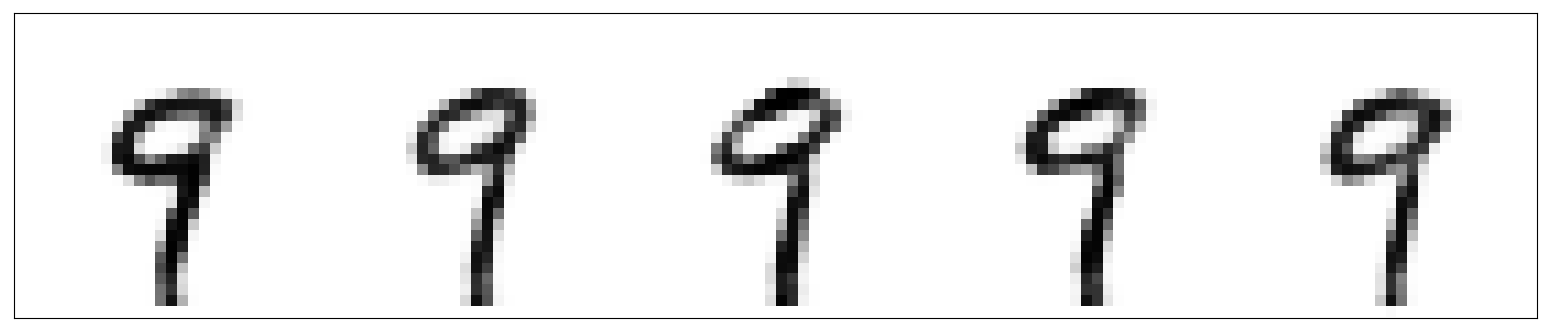

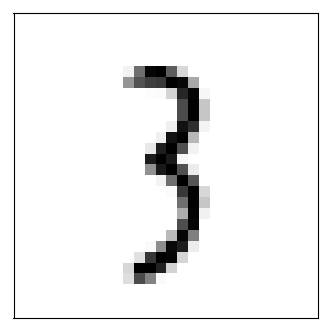

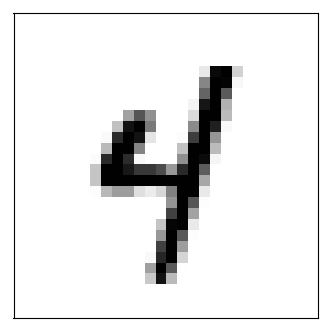

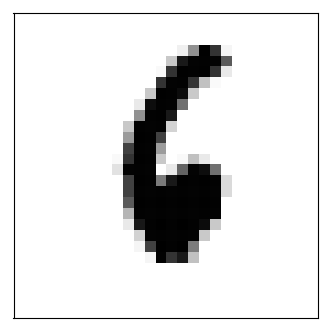

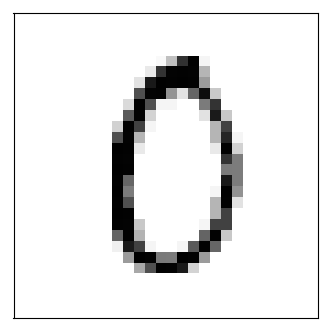

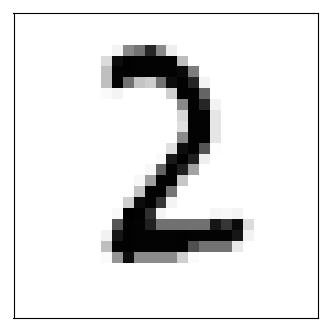

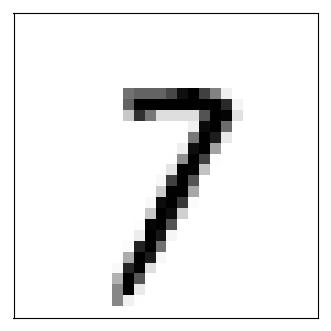

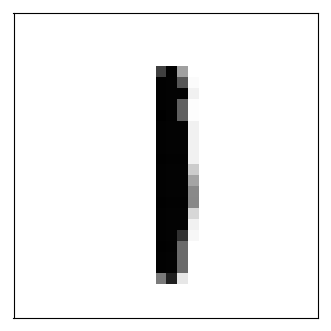

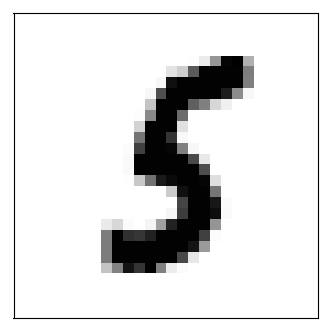

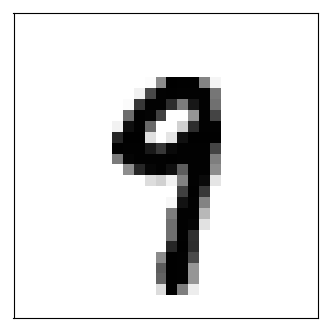

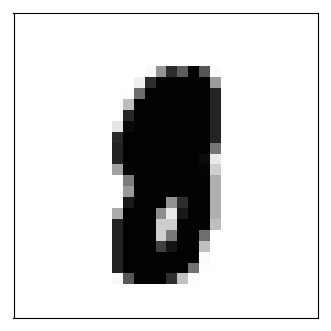

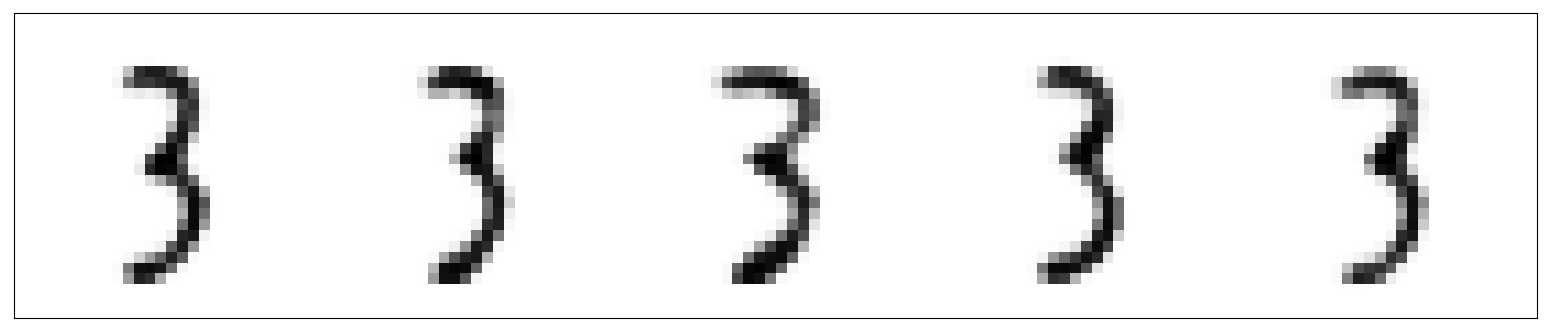

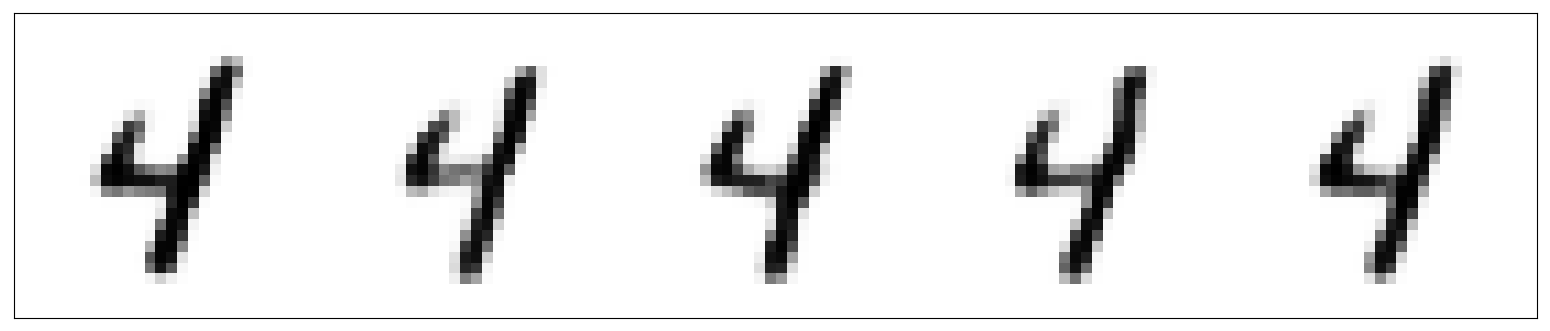

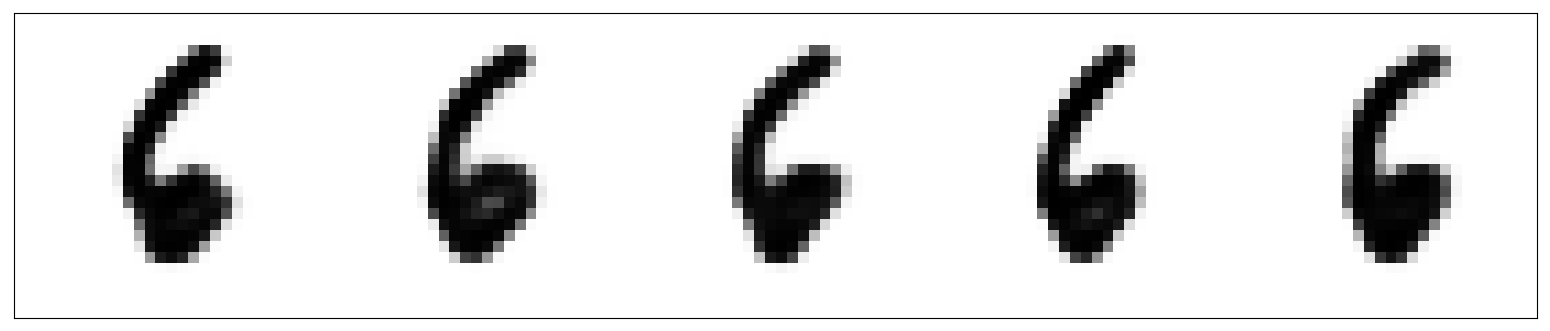

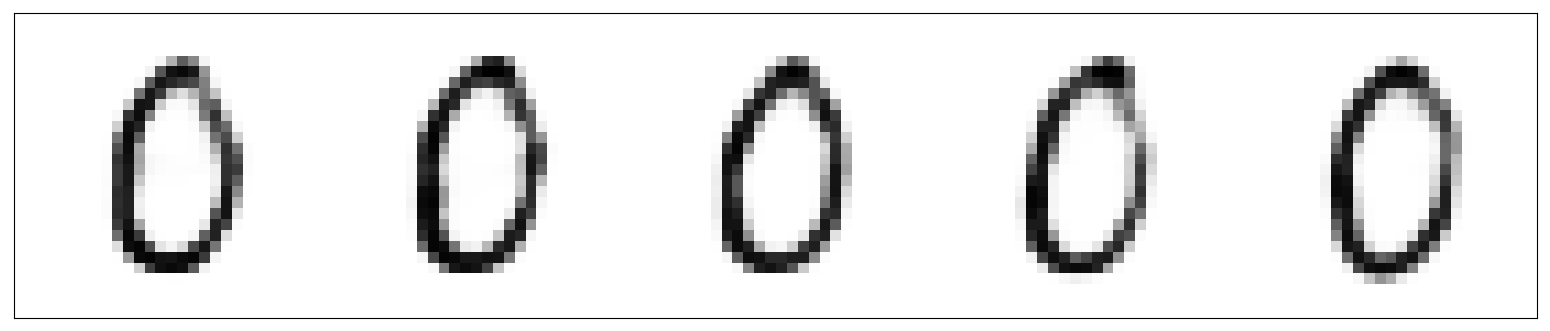

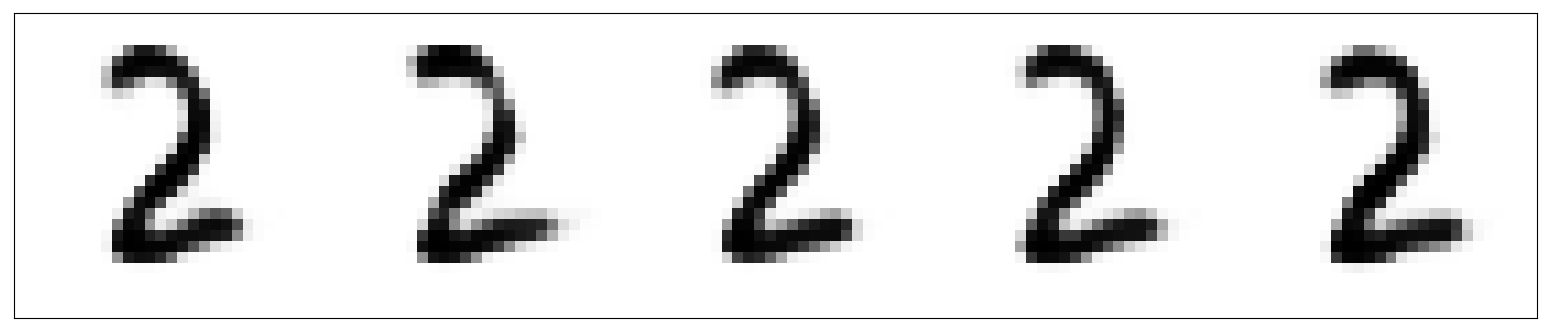

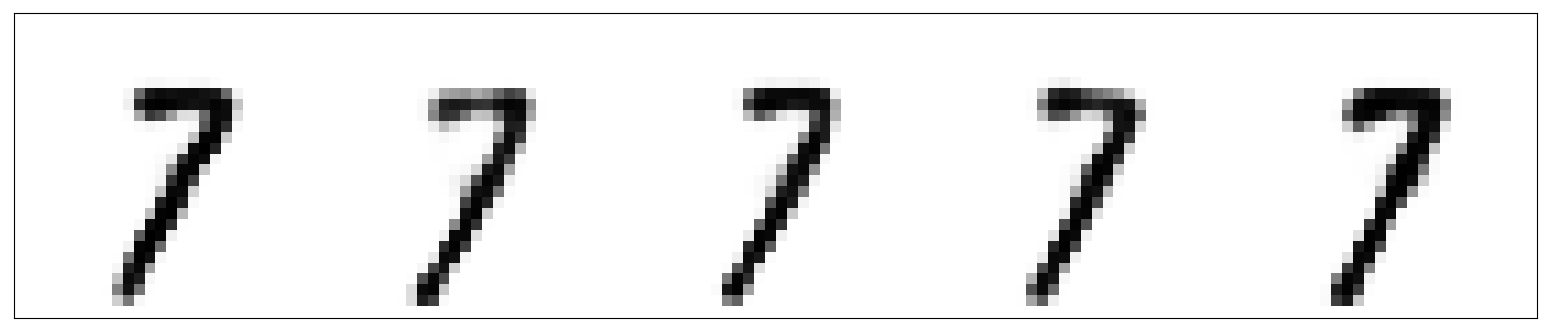

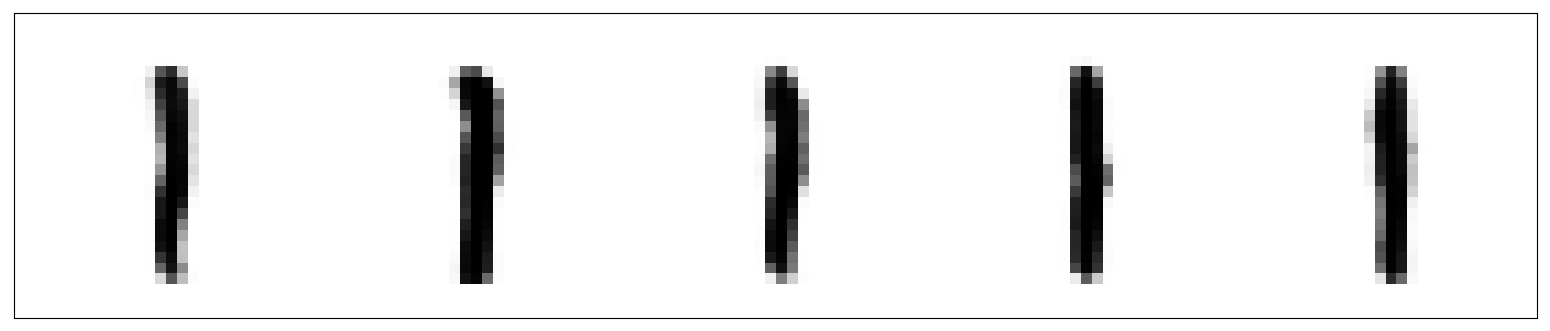

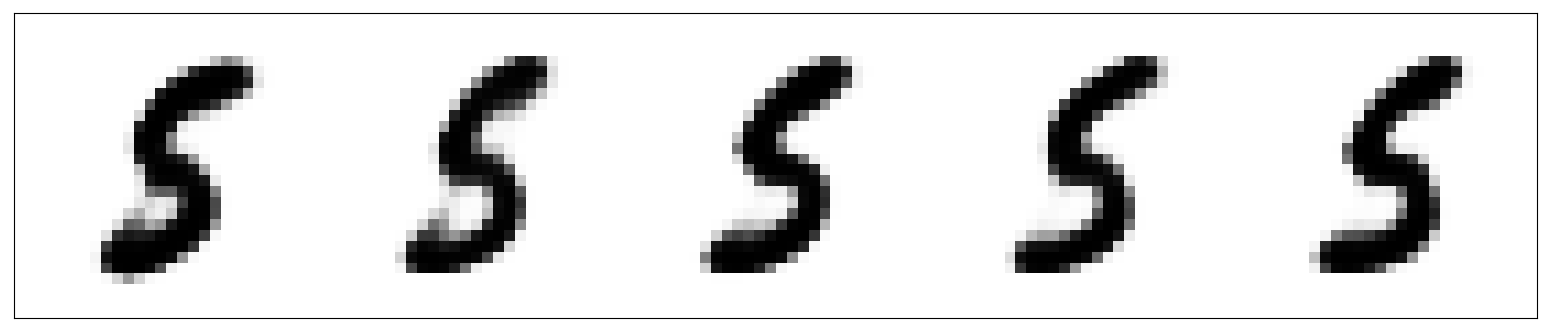

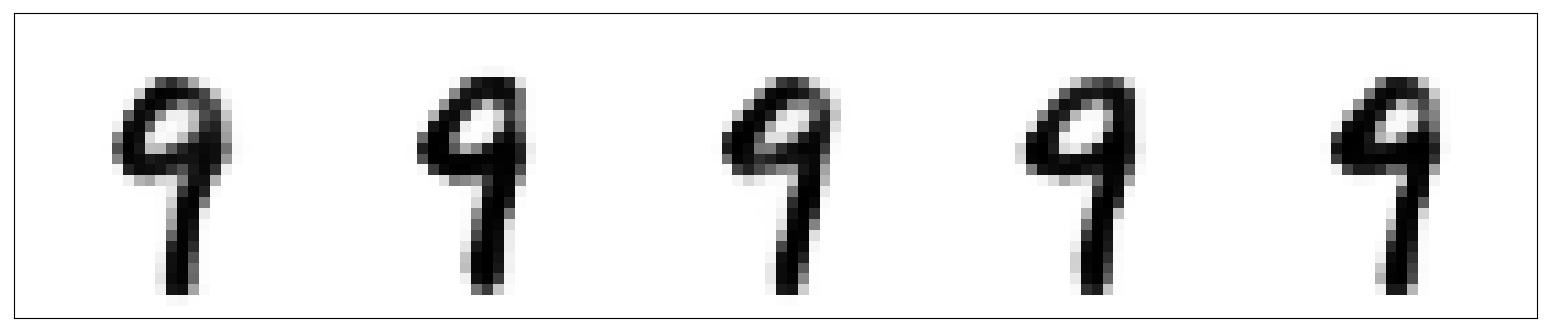

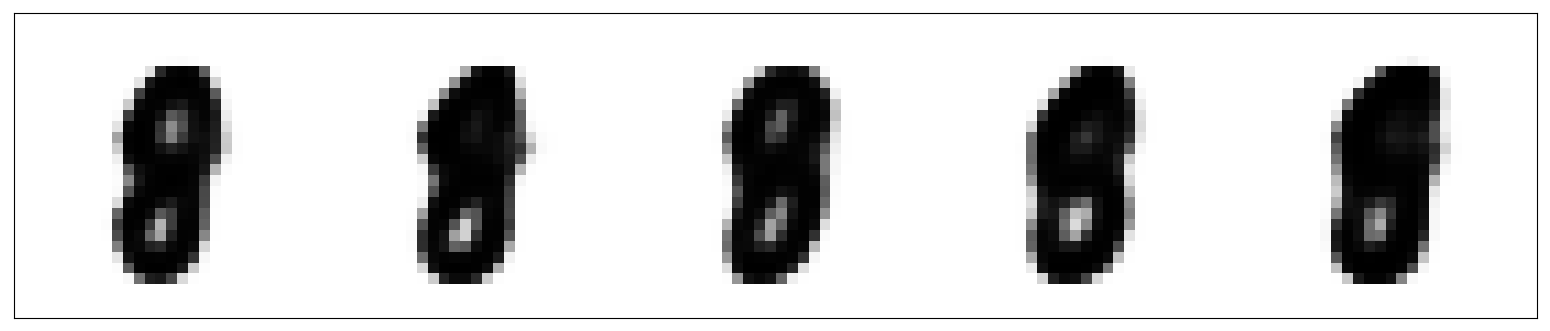

In [110]:
min_var = np.argwhere(df['var_V'].apply(lambda x: x in df.groupby('class')['var_V'].min().get_values())).T[0]
max_var = np.argwhere(df['var_V'].apply(lambda x: x in df.groupby('class')['var_V'].max().get_values())).T[0]
min_iwae = np.argwhere(df['mean_V'].apply(lambda x: x in df.groupby('class')['mean_V'].min().get_values())).T[0]
max_iwae = np.argwhere(df['mean_V'].apply(lambda x: x in df.groupby('class')['mean_V'].max().get_values())).T[0]

plot_save_min_max(y_test[min_var], 'min_var', x_test[min_var])
plot_save_min_max(y_test[max_iwae], 'max_iwae', x_test[max_iwae])

### 3.3.2 Result 6
Sampling good / bad elbos from the latent space against sampling good / bad variances.

In [111]:
if latent_dim == 2:
    x = y = linspace(-5, 5, 300)
    X, Y = np.meshgrid(x, y)
    latent_samples = 400
    for num in range(10):
        df_num = df[df['class'] == num]
        df_samples = df_num.sample(n=latent_samples)
        idx_samples = df_samples.index.tolist()
        z_mean_sample, log_z_var_sample = encoder_model.predict(x_test[idx_samples], batch_size=2000)
        z_std_sample = np.exp(log_z_var_sample/2)
        
        latent_dist = np.mean([
            1/sqrt(2*pi*std[0]) * 1/sqrt(2*pi*std[1]) 
            * np.exp(-(X - mu[0])**2 / (2 * std[0]**2)) * np.exp(-(Y - mu[1])**2 / (2 * std[1]**2)) 
            for mu, std in zip(z_mean_sample, z_std_sample)
        ], axis=0)
        
        df_top_iwae = df_num.sort_values('iwae', ascending=False).head(10)
        idx_top_iwae = df_top_iwae.index.tolist()
        z_mean_iwae, _ = encoder_model.predict(x_test[idx_top_iwae], batch_size=2000)
        
        df_top_var = df_num.sort_values('var_V', ascending=True).head(10)
        idx_top_var = df_top_var.index.tolist()
        z_mean_var, _ = encoder_model.predict(x_test[idx_top_var], batch_size=2000)
        
        fig, ax = plt.subplots(figsize=(3.2, 3.2))
        ax.pcolormesh(X, Y, latent_dist, cmap='Greys_r')
        ax.scatter(z_mean_iwae[:, 0], z_mean_iwae[:, 1], c='g', s=12, marker='o')
        ax.scatter(z_mean_var[:, 0], z_mean_var[:, 1], c='b', s=12, marker='^')
        ax.set_xticks(())
        ax.set_yticks(())
        
        ax.text(
            0.07, 0.93, str(num),
            fontdict = {
                'family': 'sans-serif',
                'color': 'white',
                'name': 'arial',
                'size': 12,
                'weight': 'black',
                'usetex': False
            },
            transform=ax.transAxes,
            verticalalignment='center',
            horizontalalignment='center'
        )
        
        
        show()
        fig.savefig('./Figures/latent_spaces/%d_latent_space.pdf' %num)

### 3.3.3 Result 7
Average distance from the mean for the best iwae / var samples.

In [115]:
top_samples = 10
classes = []
iwae_dists = []
var_dists = []

dist_path = './data/nips/distances_%d_samples_l_%d.csv' %(top_samples, latent_dim)

for num in range(10):
    df_num = df[df['class'] == num]
    idx_samples = df_num.index.tolist()
    z_mean_sample, _ = encoder_model.predict(x_test[idx_samples], batch_size=2000)
    
    df_top_iwae = df_num.sort_values('iwae', ascending=False).head(top_samples)
    idx_top_iwae = df_top_iwae.index.tolist()
    z_mean_iwae, _ = encoder_model.predict(x_test[idx_top_iwae], batch_size=2000)

    df_top_var = df_num.sort_values('var_V', ascending=True).head(top_samples)
    idx_top_var = df_top_var.index.tolist()
    z_mean_var, _ = encoder_model.predict(x_test[idx_top_var], batch_size=2000)
    
    z_mean = np.mean(z_mean_sample, axis=0)
    iwae_distance = np.mean(linalg.norm(z_mean_iwae - z_mean, axis=1))
    var_distance = np.mean(linalg.norm(z_mean_var - z_mean, axis=1))
    
    classes.append(num)
    iwae_dists.append(iwae_distance)
    var_dists.append(var_distance)
    
df_dists = pd.DataFrame(data=array([classes, iwae_dists, var_dists]).T, columns=['class', 'IWAE distance', 'VAR distance'])
df_dists.to_csv(dist_path, index=False)
df_dists

,class,IWAE distance,VAR distance
0,0.0,2.850574,2.340403
1,1.0,2.041625,1.750382
2,2.0,3.513714,3.591965
3,3.0,3.102333,2.791945
4,4.0,2.866394,2.854370
5,5.0,3.358417,3.100240
6,6.0,3.083055,2.721152
7,7.0,2.608751,2.356300
8,8.0,3.155239,2.683322
9,9.0,2.668302,2.397213


### 3.3.4 Result 8
Relationship between kl term, image term, and the second order correction.

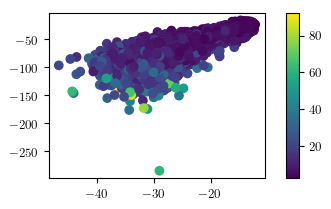

In [132]:
kl_term = df['kl_loss'].get_values()
im_term = df['im_loss'].get_values()
var_term = df['var_V'].get_values()
scatter(kl_term, im_term, c=var_term)
colorbar()

## 3.4 Neural Network - Linear Gaussian Model

In [417]:
# VAE model from "Auto Encoding Variation Bayes": https://arxiv.org/pdf/1312.6114.pdf
# encoder model is modelled by a gaussian, producing the latent
# variables mean and its log standard deviation

def gauss_model(latent_dim, hidden_dim=200):
    # encoder shared layers
    enc_hid = Dense(hidden_dim, activation='relu', name='enc_hidden')
    #z_mean = Dense(latent_dim, name='latent_mean')
    #log_z_var = Dense(latent_dim, name='log_latent_var')
    enc_layer = Encoder(latent_dim, name='enc_mean')
    
    # decoder shared layers
    dec_hid = Dense(hidden_dim, activation='relu', name='dec_hidden')
    #dec_mean = Dense(28*28, name='dec_mean')
    #log_dec_var = Dense(1, name='log_dec_var')
    dec_layer = Decoder(28*28, name='dec_mean')
    
    # encoder model
    enc_in = Input(shape=(784,), name='enc_input')
    #y = enc_hid(enc_in)
    y = enc_in
    #y_1 = z_mean(y)
    #y_2 = log_z_var(y)
    y_1, y_2 = enc_layer(y)
    enc_model = Model(enc_in, y_1, name='encoder_model')
    
    # decoder model
    dec_in = Input(shape=(latent_dim,), name='dec_in')
    #y = dec_hid(dec_in)
    y = dec_in
    #y_1 = dec_mean(y)
    #y_2 = log_dec_var(y)
    y_1, y_2 = dec_layer(y)
    dec_model = Model(dec_in, y_1, name='decoder model')
    
    # encoder - decoder model
    y = enc_in
    #y = enc_hid(y)
    #z_mean = z_mean(y)
    #log_z_var = log_z_var(y)
    z_mean, log_z_var = enc_layer(y)
    y = Sampler(always_sample=True, name='z_sampler')([z_mean, log_z_var])
    #y = dec_hid(y)
    #dec_mean = dec_mean(y)
    #log_dec_var = log_dec_var(y)
    dec_mean, log_dec_var = dec_layer(y)
    #y = Sampler(name='out_sampler')([dec_mean, log_dec_var])
    enc_dec_model = Model(enc_in, dec_mean, name='encdec model')
    
    return (enc_model, dec_model, enc_dec_model), (z_mean, log_z_var), (dec_mean, log_dec_var)
    
    
# to properly make a global decoder variance, we need a decoder layer


class Decoder(Dense):
    
    #def __init__(self, units, **kwargs):
    #    super(Decoder, self).__init__(units, **kwargs)
    
    def build(self, input_shape):
        self.log_dec_var = self.add_weight(
            name='log_dec_var',
            shape=(1,),
            initializer='zeros'
        )
        super(Decoder, self).build(input_shape)
        
    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
            
        output = [output, self.log_dec_var]
        
        return output
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return [tuple(output_shape), (1,)]
    
    
# to properly make a global latent variance, we need an encoder layer    
    
    
class Encoder(Dense):
    
    def __init__(self, units, always_sample=False, **kwargs):
        self.always_sample = False
        super(Encoder, self).__init__(units, **kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) >= 2
        
        self.log_z_mean = self.add_weight(
            name='log_z_mean',
            shape=(self.units,),
            initializer='zeros'
        )
        super(Encoder, self).build(input_shape)
        
    def call(self, inputs):
        z_mean = K.dot(inputs, self.kernel)
        if self.use_bias:
            z_mean = K.bias_add(z_mean, self.bias, data_format='channels_last')
        if self.activation is not None:
            z_mean = self.activation(z_mean)
            
        output = [z_mean, self.log_z_mean]
        
        return output
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return [tuple(output_shape), (self.units,)]

In [578]:
latent_dim = 200
hidden_dim = 200

models, latent_vars, dec_outs = gauss_model(latent_dim, hidden_dim)
enc_model, dec_model, enc_dec_model = models
z_mean, log_z_var = latent_vars
dec_mean, log_dec_var = dec_outs

# elbo loss
def gauss_loss(y_true, y_pred):
    kl_loss = - 1/2 * K.sum(1 + log_z_var - K.square(z_mean) - K.exp(log_z_var), axis=-1)
    im_loss = (
        1/2 * 784 * (K.log(2*pi) + log_dec_var)
        + 1/2 * K.batch_dot(y_true - dec_mean, (y_true-dec_mean) * K.exp(-log_dec_var), axes=-1)
    )[:, 0]
    return kl_loss + im_loss

enc_dec_model.compile(optimizer='adam', loss=gauss_loss)

# train and save the model
epochs = 50
batch_size = 256

if not os.path.exists('./models/linear/'):
    os.makedirs('./models/linear')

dec_path = './models/linear/dec_model_%d_dim.weights' %latent_dim
weights_path = './models/linear/enc_dec_model_%d_dim.weights' %latent_dim
history_path = './models/linear/history_%d_dim.pkl' %latent_dim

nb_regions = 4
regions = cumsum([3**i for i in range(nb_regions+1)]) + 50
schedule = lambda i, lr: 0.001 * 10**(-sum(regions <= i)/nb_regions)

lr_schedule = LearningRateScheduler(schedule)

epochs = regions[-1]
batch_size = 512

if not os.path.exists(weights_path):
    # training
    history = enc_dec_model.fit(
        x=x_train.reshape(len(x_train), 784), y=x_train.reshape(len(x_train), 784),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[lr_schedule]
    )
    # enc_dec_model represents the whole dec_model as a single layer
    # so we have to save the decoder weights seperately
    dec_model.save_weights(dec_path) # hacky fix for decoder weights
    enc_dec_model.save_weights(weights_path)
    # save history
    history = history.history
    pickle.dump(history, open(history_path, 'wb'))
    print('Model Saved')
else:
    dec_model.load_weights(dec_path, by_name=True)
    enc_model.load_weights(weights_path, by_name=True)
    enc_dec_model.load_weights(weights_path, by_name=True)
    history = pickle.load(open(history_path, 'rb'))
    print('Model Loaded')

Epoch 1/171
60000/60000 [==============================] - 5s 79us/step - loss: 772.0051
Epoch 2/171
60000/60000 [==============================] - 3s 45us/step - loss: 677.6168
Epoch 3/171
60000/60000 [==============================] - 3s 47us/step - loss: 630.7890
Epoch 4/171
60000/60000 [==============================] - 3s 49us/step - loss: 585.7323
Epoch 5/171
60000/60000 [==============================] - 3s 46us/step - loss: 541.7906
Epoch 6/171
60000/60000 [==============================] - 3s 46us/step - loss: 498.8524
Epoch 7/171
60000/60000 [==============================] - 3s 48us/step - loss: 456.5547
Epoch 8/171
60000/60000 [==============================] - 3s 49us/step - loss: 414.5360
Epoch 9/171
60000/60000 [==============================] - 3s 45us/step - loss: 372.5899
Epoch 10/171
60000/60000 [==============================] - 3s 44us/step - loss: 331.0292
Epoch 11/171
60000/60000 [==============================] - 3s 51us/step - loss: 290.0465
Epoch 12/171
60000/

In [579]:
W, sigma = calculate_W_sigma(x_train, S, l=latent_dim)
d, l = W.shape
M = matmul(W.T, W) + sigma * eye(l)
C = matmul(W, W.T) + sigma * eye(d)
detsign, detlog = linalg.slogdet(2 * pi * C)
b = np.mean(x_train, axis=0)

# mu_z_x_test = matmul(matmul(inv(M), W.T), x_test - b)
# var_z_x_test = sigma * inv(M)


# nb_samples = 10
# z_samples = array([random.multivariate_normal(mu[:, 0], var_z_x_test, size=(nb_samples)) for mu in mu_z_x_test])
# z_samples = z_samples.transpose(1, 0, 2)
# z_samples = np.expand_dims(z_samples, -1)

# x_samples = matmul(W, z_samples) + b


log_p_x = -1/2 * detlog - 1/2 * matmul(matmul((x_test-b).transpose(0, 2, 1), inv(C)), x_test-b)
log_p_x = log_p_x[:, 0, 0]

In [580]:
np.mean(log_p_x)

498.584484085348

In [581]:
z_mean = enc_model.predict(x_test[:, :, 0])
enc_var_nn = np.diag(np.exp(K.eval(log_z_var)))
dec_var_nn = np.exp(K.eval(log_dec_var)) * eye(d)

nb_samples = 20
z_samples = array([random.multivariate_normal(mu, enc_var_nn, size=(nb_samples)) for mu in z_mean])
z_samples = z_samples.transpose(1, 0, 2)

z_mean = np.expand_dims(z_mean, -1)
z_samples = np.expand_dims(z_samples, -1)

x_samples = dec_model.predict(z_samples.reshape(nb_samples*10000, latent_dim))
x_samples = x_samples.reshape(nb_samples, 10000, 784, 1)

log_p_x_z = -1/2 * linalg.slogdet(2 * pi * dec_var_nn)[1] - 1/2 * matmul(matmul((x_test-x_samples).transpose(0, 1, 3, 2), inv(dec_var_nn)), x_test-x_samples)
log_p_z = - 1/2 * linalg.slogdet(2 * pi * eye(latent_dim))[1] - 1/2 * matmul(matmul(z_samples.transpose(0, 1, 3, 2), eye(latent_dim)), z_samples)
log_q_z_x = -1/2 * linalg.slogdet(2 * pi * enc_var_nn)[1] - 1/2 * matmul(matmul((z_samples - z_mean).transpose(0, 1, 3, 2), inv(enc_var_nn)), z_samples - z_mean)

V_z = -log_p_x_z - log_p_z + log_q_z_x

C:\Users\User\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


In [586]:
np.mean(np.log(np.mean(np.exp(-V_z), axis=0)+1e-30))

C:\Users\User\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


inf

In [583]:
np.mean(-np.mean(V_z, axis=0) + 1/2 * np.var(V_z, axis=0))

839.3210877111624

In [584]:
-np.mean(V_z)

837.2269999754532